# Instrucciones
1. Identificar viajes que vuelven vacios o con espacios disponibles
2. Cuantificar la oportunidad de ahorro
3. Identificar ineficiencias en cargas y descargas 
4. Destaca otros insights de la data analizada

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
#import numpy as np
#import seaborn as sb

In [243]:
df= pd.read_csv('data.csv')
#df.info()

In [245]:
print(f"L cantidad de datos que hay son : (filas x columnas) = {df.shape}")


L cantidad de datos que hay son : (filas x columnas) = (6880, 32)


In [ ]:
df.head()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6880 entries, 0 to 6879
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   GpsProvider                         5927 non-null   object 
 1   BookingID                           6880 non-null   object 
 2   Market/Regular                      6880 non-null   object 
 3   BookingID_Date                      6880 non-null   object 
 4   vehicle_no                          6880 non-null   object 
 5   Origin_Location                     6880 non-null   object 
 6   Destination_Location                6880 non-null   object 
 7   Org_lat_lon                         6880 non-null   object 
 8   Des_lat_lon                         6880 non-null   object 
 9   Data_Ping_time                      5927 non-null   object 
 10  Planned_ETA                         6880 non-null   object 
 11  Current_Location                    5916 no

# VERIFICAR QUE NO EXISTA DATOS DUPLICADOS

In [65]:
duplicados = df.duplicated().sum()
print(f"Número de filas duplicadas: {duplicados}")

Número de filas duplicadas: 0


In [133]:
if df['vehicle_no'].dtype == 'object':
    whitespace_vehicles = (df['vehicle_no'].str.isspace()).sum()
else:
    whitespace_vehicles = 0

print(f"Whitespace-only values: {whitespace_vehicles}")

Whitespace-only values: 0


# insights de la data analizada 
Existen vehiculos con mas una considerable diferencia en la cantidad de viajes que relizan 

In [135]:
num_vehiculos_unicos = df['vehicle_no'].nunique()
num_vehiculos_unicos

2325

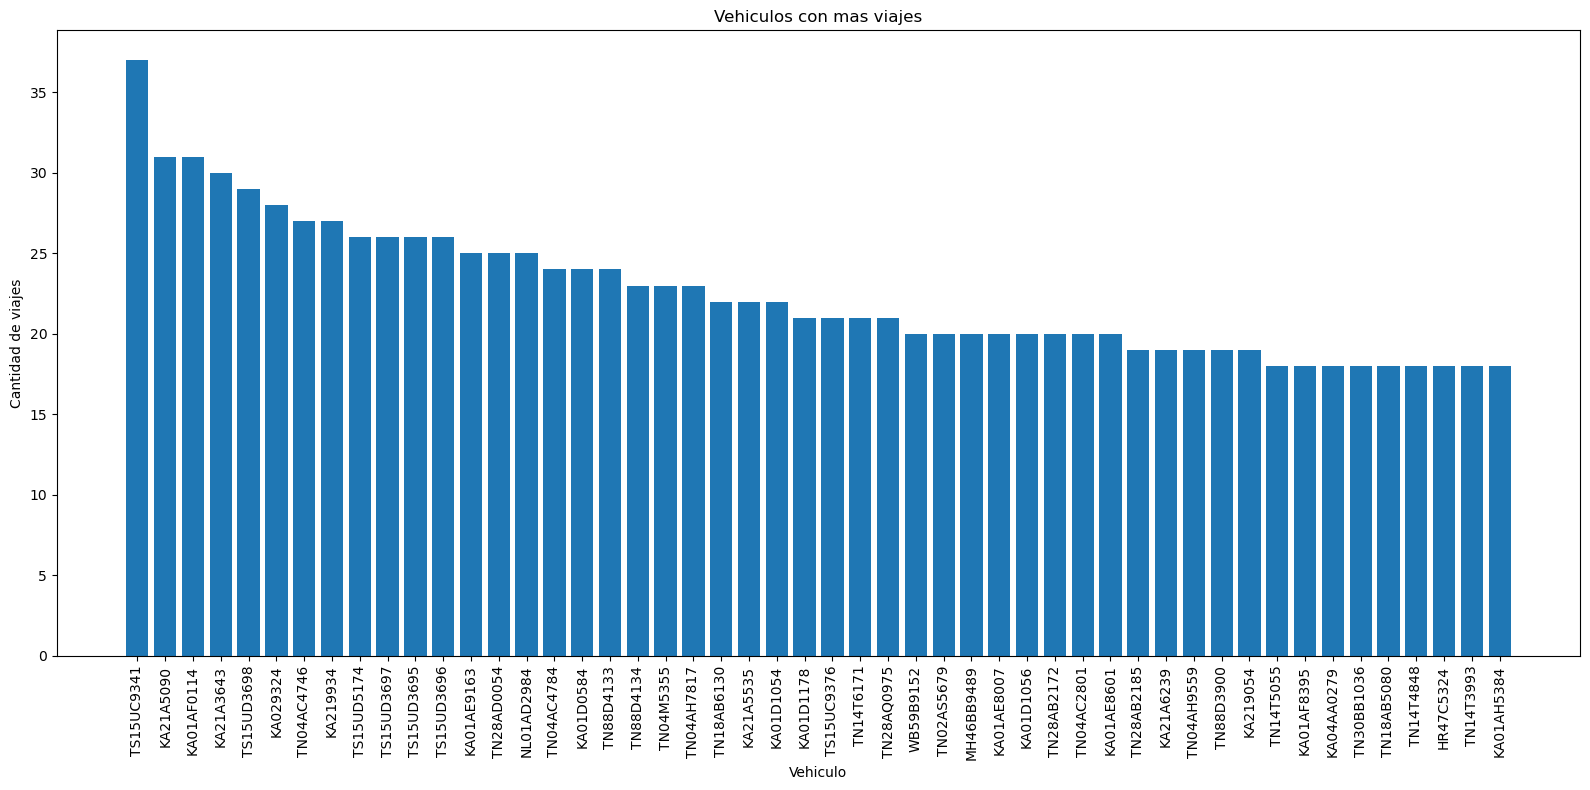

In [156]:

viajes_por_vehiculo = df['vehicle_no'].value_counts().reset_index()
viajes_por_vehiculo.columns = ['vehicle_no', 'total_viajes']
vehiculos = viajes_por_vehiculo.head(50)

plt.figure(figsize=(16, 8))
plt.title('Vehiculos con mas viajes')
plt.bar(vehiculos['vehicle_no'], vehiculos['total_viajes'])
plt.xticks(rotation=90, ha='center')
plt.xlabel('Vehiculo')
plt.ylabel('Cantidad de viajes')
plt.tight_layout()
plt.show()


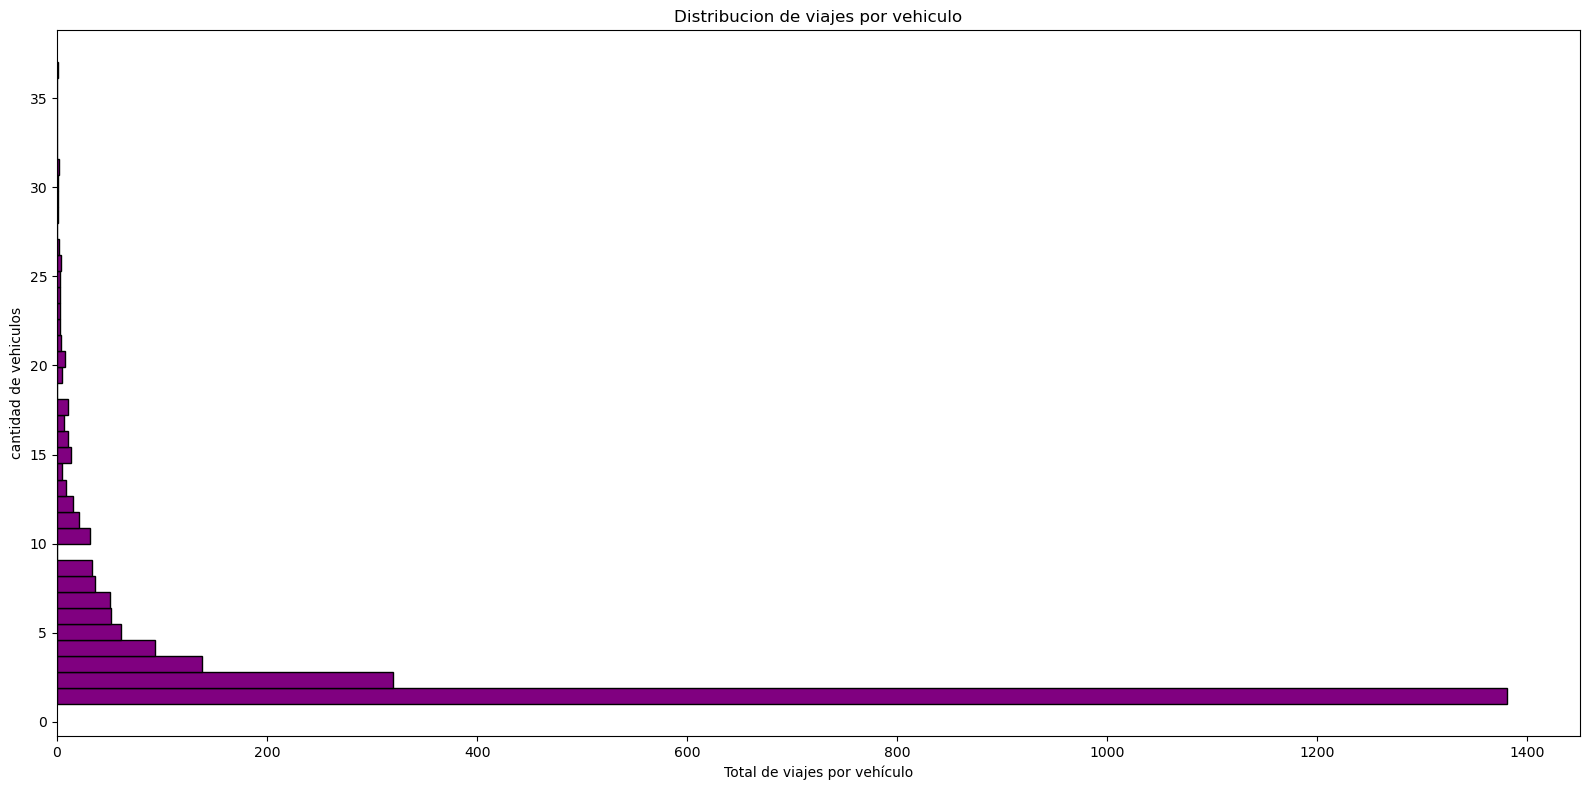

In [236]:
plt.figure(figsize=(16, 8))

plt.hist(viajes_por_vehiculo['total_viajes'], bins=40, color='purple', edgecolor='black',orientation='horizontal')
plt.xlabel('Total de viajes por vehículo')
plt.ylabel('cantidad de vehiculos')
plt.title('Distribucion de viajes por vehiculo')

plt.tight_layout()
plt.show()

# Identificar viajes que vuelven vacíos o con espacio disponible
### 1. Los vehículos que vuelven vacios son cuyas material enviado es "XXXXXX"
### 2. Los vehículos que vuelven espacio disponibles son aquellos cuyo material enviado tienen la palabra "EMPTY"

In [254]:
def clasificacion(material):
    if pd.isna(material):
        return 'Unknown'
    material = material.strip().upper()
    if material == 'XXXXXX':
        return 'Empty'
    elif 'EMPTY' in material:
        return 'Minimal Load'
    else:
        return 'Full Load'

df_sorted = df.sort_values(by=['vehicle_no', 'trip_start_date']).copy()

df_sorted['Load_Clasf'] = df_sorted['Material Shipped'].apply(clasificacion)

df_sorted['Prev_Destination'] = df_sorted.groupby('vehicle_no')['Destination_Location'].shift(1)
df_sorted['Prev_trip_end_date'] = df_sorted.groupby('vehicle_no')['trip_end_date'].shift(1)

df_sorted['Is_Return'] = (
    (df_sorted['Origin_Location'] == df_sorted['Prev_Destination']) &
    (df_sorted['trip_start_date'] > df_sorted['Prev_trip_end_date'])
)

df_sorted['Is_Empty_Return'] = (
    df_sorted['Is_Return'] &
    (df_sorted['Load_Clasf'].isin(['Empty', 'Minimal Load'])) 
)

num_empty_returns = df_sorted['Is_Empty_Return'].sum()
print("La cantidad de retornos vacíos o casi vacios son:", num_empty_returns)




La cantidad de retornos vacíos o casi vacios son: 94


## Tabla con los vehiculos que cumplen la condicion de vacio o con espacio disponible


In [256]:
df_sorted[df_sorted['Is_Empty_Return']][['vehicle_no', 'Is_Empty_Return']]


,vehicle_no,Is_Empty_Return
831,GJ01DZ3696,True
832,GJ01ET3759,True
211,GJ01FT1955,True
1164,GJ01HT6369,True
1176,GJ38T0650,True
...,...,...
1085,TN88D4133,True
740,TN88D4133,True
409,TN88D4133,True
407,TN88D4134,True


# Cuantificar la oportunidad de ahorro
## Lo que se podria ahorrar si los vehiculos estuvieran cargados al 100% 
### ahorro total = ingreso - gasto por transporte vacio
### gasto por transporte vacio = Kilometros recorridos * costo de transporte por km
### ingreso esperado = kilometros recorridos * ingreso de carga por km

In [197]:
costo_km = 4
ingreso_por_km_cargado = 60

empty_returns = df_sorted[df_sorted['Is_Empty_Return']].copy()
empty_returns['costo_retorno'] = empty_returns['TRANSPORTATION_DISTANCE_IN_KM'] * costo_km
empty_returns['ingreso_posible'] = empty_returns['TRANSPORTATION_DISTANCE_IN_KM'] * ingreso_por_km_cargado
empty_returns['ahorro_potencial'] = empty_returns['ingreso_posible'] - empty_returns['costo_retorno']

ahorro_total = empty_returns['ahorro_potencial'].sum()
print(f" ahorrro en bs= {ahorro_total}")
print(f" perdidas de vehiculos vacios o semi vacios en bs= {empty_returns['costo_retorno'].sum()}")
#print(f" procentaje de ahorro = {ahorro_total/empty_returns['ingreso_posible'].sum()}")
#print(f" procentaje de perdidas por vehiculos vacios o semi vacios= {empty_returns['costo_retorno'].sum()/}")


 ahorrro en bs= 3639272.0
 perdidas de vehiculos vacios o semi vacios en bs= 259948.0
 procentaje de ahorro = 0.9333333333333333
